<a href="https://colab.research.google.com/github/pellet/deep-learning-for-coders/blob/master/arshy_EEGInception_approach2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

paper : https://arxiv.org/abs/2101.10932
https://github.com/esantamariavazquez/EEG-Inception/blob/main/EEGInception/EEGInception.py

In [ ]:
!pip install fastai timm -Uqq

     |████████████████████████████████| 189 kB 5.4 MB/s 
     |████████████████████████████████| 431 kB 44.3 MB/s 
     |████████████████████████████████| 55 kB 3.8 MB/s 


In [ ]:
import torch
import torch.nn as nn
import timm
from timm import create_model
from timm.models.efficientnet_blocks import DepthwiseSeparableConv
from timm.models.layers import create_conv2d
from fastai.vision.all import *
from glob import glob
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/colab_notebooks/algovera/lynxhack

/content/drive/MyDrive/colab_notebooks/algovera/lynxhack


In [ ]:
def read_eeg(fn):
    x= np.expand_dims(np.load(fn), 0)
    ss = pickle.load(open('ss_approach2.pkl', 'rb'))
    x = ss.transform(x)
    return np.expand_dims(x.squeeze(), -1)
    
def EEGBlock():
    return TransformBlock(type_tfms=read_eeg)

class EEGCallback(Callback):
    def before_batch(self):
        self.learn.xb = (self.learn.xb[0].reshape(-1, 61, 5000).unsqueeze(-1), )
        self.learn.yb = (self.learn.yb[0].repeat(6,1).T.flatten(), )

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self,
        in_chs,
        out_chs,
        kernel_size,
        dropout_rate,
        activation,
        depth_multiplier=2
    ):
        super().__init__()
        
        self.conv = nn.Conv2d(in_chs,
                              out_chs,
                              kernel_size=kernel_size,
                              padding='same')

        self.bn = nn.BatchNorm2d(out_chs)
        self.act = activation()
        self.dp = nn.Dropout2d(dropout_rate)
        self.dconv = DepthwiseSeparableConv(in_chs=out_chs,
                                            out_chs=out_chs*depth_multiplier)
        self.bn2 = nn.BatchNorm2d(out_chs*depth_multiplier)
        self.act2 = activation()
        self.dp2 = nn.Dropout2d(dropout_rate)

    def forward(self, x):

        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.dp(x)
        x = self.dconv(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.dp2(x)

        return x

In [ ]:
class EEGInception(nn.Module):
    def __init__(self,
        n_channels=61, # Num channels
        input_time=5000, # Input time
        fs=100,         # Frequence
        scales_time=(500, 250, 125), 
        dropout_rate=0.25,
        activation=nn.ELU,
        num_filters=16, 
        n_classes=5,
        block_depth_multiplier=2
    ):

        super().__init__()
        self.scales_samples = [int(s * fs / 1000) for s in scales_time]
        self.num_channels = n_channels
        self.dropout_rate = dropout_rate

        self.blocks1 = nn.ModuleList()
        for i in range(len(scales_time)):
            self.blocks1.append(InceptionBlock(
                                        in_chs=self.num_channels,
                                        out_chs=num_filters,
                                        kernel_size=(scales_time[i], 1),
                                        dropout_rate=self.dropout_rate,
                                        activation=activation,
                                        depth_multiplier=block_depth_multiplier
                                    ))

        self.avgpooling = nn.AvgPool2d(kernel_size=(4,1))

        block2_nin = num_filters*block_depth_multiplier*3
        self.blocks2 = nn.ModuleList()
        for i in range(len(scales_time)):
            self.blocks2.append(InceptionBlock(
                                        in_chs=block2_nin,
                                        out_chs=num_filters*2,
                                        kernel_size=(scales_time[i], 1),
                                        dropout_rate=self.dropout_rate,
                                        activation=activation,
                                        depth_multiplier=block_depth_multiplier
                                    ))

        self.avgpooling2 = nn.AvgPool2d(kernel_size=(4,1))

        self.conv1 = nn.Conv2d(num_filters*2*block_depth_multiplier*3, 
                               int(num_filters*len(self.scales_samples)/2),
                               kernel_size=(8, 1),
                               padding='same')
        self.bn1 = nn.BatchNorm2d(int(num_filters*len(self.scales_samples)/2))
        self.act1 = nn.ELU()
        self.avgpooling3 = nn.AvgPool2d(kernel_size=(8,1))
        self.dp1 = nn.Dropout2d(dropout_rate)

        self.conv2 = nn.Conv2d(int(num_filters*len(self.scales_samples)/2),
                               int(num_filters*len(self.scales_samples)/4),
                              kernel_size=(4, 1),
                              padding='same')
        self.bn2 = nn.BatchNorm2d(int(num_filters*len(self.scales_samples)/4))
        self.act2 = nn.ELU()
        self.avgpooling4 = nn.AvgPool2d(kernel_size=(2,1))
        self.dp2 = nn.Dropout2d(dropout_rate)

        self.flatten = nn.Flatten()
        self.final = nn.Linear(228, 5)


    def forward(self, x):
        
        block1_outs = []
        for block in self.blocks1:
            block1_outs.append(block(x))
        x = torch.cat(block1_outs, 1)
        x = self.avgpooling(x)

        block2_outs = []
        for block in self.blocks2:
            block2_outs.append(block(x))
        x = torch.cat(block2_outs, 1)
        x = self.avgpooling2(x)
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.avgpooling3(x)
        x = self.dp1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.avgpooling4(x)
        x = self.dp2(x)

        x = self.flatten(x)
        x = self.final(x)
        return x

In [ ]:
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.preprocessing import StandardScaler

class SScaler3D(BaseEstimator,TransformerMixin):

    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self,X,y=None):
        self.scaler.fit(X.reshape(X.shape[0], -1))
        return self

    def transform(self,X):
        return self.scaler.transform(X.reshape(X.shape[0], -1)).reshape(X.shape)

In [ ]:
# fns = glob('processeddata/individuals/afterica/*approach2.npy')
# fns_2 = []
# label = []
# subject = []
# session = []
# for fn in fns:
#     fns_2.append(fn)
#     label.append(str(fn).split('/')[-1].split('_')[0])
#     subject.append(str(fn).split('/')[-1].split('_')[1])
#     session.append(str(fn).split('/')[-1].split('_')[2])

# df = pd.DataFrame([fns_2, label, subject, session]).T
# df.columns = ['fns', 'label', 'subject', 'session']

# val_subs = ['sub-51', 'sub-52', 'sub-53', 'sub-54', 'sub-55', 'sub-56', 'sub-57', 'sub-58', 'sub-59', 'sub-60']
# df['is_valid'] = False
# df.loc[df[df['subject'].isin(val_subs)].index, 'is_valid'] = True

# df.to_csv('approach2infos.csv', index=False)

# features = []
# for fn in df[df['is_valid']==False].fns.values:
#     features.append(np.load(fn))

# features = np.stack(features, 0)

# ss = SScaler3D()
# ss.fit(features)

# pickle.dump(ss, open('ss_approach2.pkl', 'wb'))

In [ ]:
df = pd.read_csv('approach2infos.csv')

## EEGInception

In [ ]:
dblock = DataBlock(blocks    = (EEGBlock, CategoryBlock),
                   get_x     = ColReader('fns'),
                   get_y     = ColReader('label'),
                   splitter  = ColSplitter())

dls = dblock.dataloaders(df)

In [ ]:
model = EEGInception()   
apply_init(model, nn.init.kaiming_normal_)

In [ ]:
learn = Learner(dls, 
                model, 
                loss_func=LabelSmoothingCrossEntropyFlat(),
                cbs=[GradientClip(),
                    # EEGCallback(),
                     SaveModelCallback(fname='chrononet')],
                metrics=accuracy
        ).to_fp16()

SuggestedLRs(valley=0.02754228748381138)

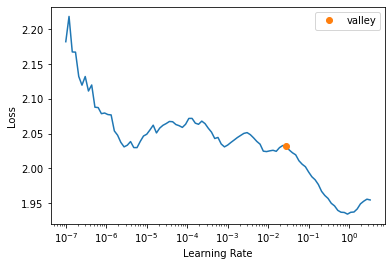

In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time
0,1.958119,1.637816,0.251701,02:19
1,1.807948,1.573004,0.292517,00:55
2,1.724823,1.548850,0.326531,00:54
3,1.670265,1.532260,0.299320,00:54
4,1.620764,1.522656,0.312925,00:54
5,1.579175,1.514858,0.299320,00:55
6,1.537700,1.497808,0.299320,00:55
7,1.497743,1.504873,0.333333,00:54
8,1.469422,1.547236,0.285714,00:54
9,1.428289,1.586465,0.292517,00:55


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:443: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Better model found at epoch 0 with valid_loss value: 1.637816309928894.
Better model found at epoch 1 with valid_loss value: 1.5730036497116089.
Better model found at epoch 2 with valid_loss value: 1.5488499402999878.
Better model found at epoch 3 with valid_loss value: 1.5322604179382324.
Better model found at epoch 4 with valid_loss value: 1.522655725479126.
Better model found at epoch 5 with valid_loss value: 1.5148584842681885.
Better model found at epoch 6 with valid_loss value: 1.4978079795837402.


KeyboardInterrupt: ignored

## Boosting method

In [ ]:
df_train = df[df['is_valid']==False]
df_val = df[df['is_valid']==True]

In [ ]:
train_f = []
for fn in df_train.fns.values:
    train_f.append(np.load(fn))

val_f = []
for fn in df_val.fns.values:
    val_f.append(np.load(fn))

In [ ]:
label_index = {
    'task-memory':2, 
    'task-music':4, 
    'task-eyes closed':0, 
    'task-eyes open':1,       
    'task-mathematic':3
}

In [ ]:
train_l = []
for l in df_train.label.values:
    train_l.append(label_index[l])

val_l = []
for l in df_val.label.values:
    val_l.append(label_index[l])

In [ ]:
train_f2 = np.stack(train_f, 0)
val_f2 = np.stack(val_f, 0)

train_l2 = np.stack(train_l)
val_l2 = np.stack(val_l)

In [ ]:
ss = pickle.load(open('ss_approach2.pkl', 'rb'))
train_f2_s = ss.transform(train_f2)
val_f2_s = ss.transform(val_f2)

train_f2_s = train_f2_s.reshape(train_f2_s.shape[0], -1)
val_f2_s = val_f2_s.reshape(val_f2_s.shape[0], -1)

In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

In [ ]:
rfc = RandomForestClassifier(
    n_estimators=1000
)

In [ ]:
rfc.fit(train_f2_s, train_l)

RandomForestClassifier(n_estimators=1000)

In [ ]:
preds = rfc.predict(val_f2_s)

In [ ]:
accuracy_score(val_l, preds)

0.3197278911564626

In [ ]:
confusion_matrix(val_l, preds)

array([[ 6,  5,  5,  7,  6],
       [ 1, 23,  1,  2,  2],
       [ 6,  6,  6,  6,  6],
       [ 2,  6,  7,  5, 10],
       [ 3,  8,  4, 10,  4]])

In [ ]:
pca = PCA(n_components=100)

In [ ]:
train_fs_s_pca = pca.fit_transform(train_f2_s)
val_fs_s_pca = pca.transform(val_f2_s)

In [ ]:
abc = AdaBoostClassifier(
    n_estimators=200
)

In [ ]:
abc.fit(train_fs_s_pca, train_l)

AdaBoostClassifier(n_estimators=200)

In [ ]:
preds = abc.predict(val_fs_s_pca)

In [ ]:
accuracy_score(val_l, preds)

0.23809523809523808

In [ ]:
rfc.fit(train_fs_s_pca, train_l)

RandomForestClassifier(n_estimators=1000)

In [ ]:
preds = rfc.predict(val_fs_s_pca)

In [ ]:
accuracy_score(val_l, preds)

0.24489795918367346